In [1]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
from tqdm import tqdm
import itertools
import json
from shapely.geometry import Point
from multiprocessing import Pool
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings 

plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings('ignore')

from module.osrm_api import * 
from module.slack_chat_bot import *
from module.generate_random_location import Generate_taxi_random_location

/home/yh_zoo/.local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### 1. Make up data of passenger and taxi
- 데이터 :서울 택시 승하차 데이터 
- 승객 데이터, 택시 데이터로 분리 
- 시간 단위 분으로 변경
- 추가 수요 반영을 위해 kt 이동 데이터를 기반으로 fake passenger 생성

In [2]:
def time_transform(data):
    '''
    시간 분까지만 고려 -> 분으로 변환
    '''
    #ride_dtime
    ride_date = list(map(lambda data: data.day, data['ride_dtime']))
    ride_time = data['ride_dtime'].dt.strftime('%H%M%S')
    ride_time = pd.to_datetime(ride_time, format='%H%M%S')
    
    #alight_dtime
    alight_date = list(map(lambda data: data.day, data['alight_dtime']))
    alight_time = data['alight_dtime'].dt.strftime('%H%M%S')
    alight_time = pd.to_datetime(alight_time, format='%H%M%S')
    
    #시분초 -> 0~1440분으로 변환
    ride_time = ride_time.dt.minute + ride_time.dt.hour*60
    ride_time = ride_time.tolist()
    
    alight_time = alight_time.dt.minute + alight_time.dt.hour*60
    alight_time = alight_time.tolist()
    
    days = data["ride_dtime"].iloc[0].day    
    data['ride_dtime'] = [t+1440 if d != days else t for t,d in zip(ride_time, ride_date)]
    data['alight_dtime'] = [t+1440 if d != days else t for t,d in zip(alight_time, alight_date)]
    
    return data

In [3]:
def load_20220408_taxi_data():
    # 20220404(월) ~ 20220410(일)
    taxi_202204 = pd.read_csv('./data/taxi_Data/tx_data_202204.csv')
    taxi_202204.columns = ['taxi_id', 'ride_dtime', 'ride_x', 'ride_y', 'alight_dtime', 'alight_x', 'alight_y', 'payment']

    taxi_202204['ride_dtime'] = pd.to_datetime(taxi_202204['ride_dtime'], format='%Y%m%d%H%M%S')
    taxi_202204['alight_dtime'] = pd.to_datetime(taxi_202204['alight_dtime'], format='%Y%m%d%H%M%S')

    # 타켓 시간이 2022-04-08 21:00 ~ 2022-04-09 02:00이지만, 택시 운행 스케줄을 생성하기 위해 2022-04-08 20:00 데이터 필터 후 
    # 추후에 택시 스케줄 완성 후 drop한다.  
    taxi_20220408 = taxi_202204.loc[(taxi_202204['ride_dtime'] >= pd.Timestamp(2022,4,8,20)) & (taxi_202204['ride_dtime'] < pd.Timestamp(2022,4,9,2))]
    taxi_20220408 = taxi_20220408.sort_values('ride_dtime').reset_index(drop=False)

    # ride_x, ride_y -> ride_geometry | alight_x, alight_y -> alight_geometry
    taxi_20220408['ride_geometry'] = [Point(x,y) for x,y in zip(taxi_20220408['ride_x'], taxi_20220408['ride_y'])]
    taxi_20220408['alight_geometry'] = [Point(x,y) for x,y in zip(taxi_20220408['alight_x'], taxi_20220408['alight_y'])]

    ### passenger, taxi로 분할
    ## passenger
    passenger = taxi_20220408[['ride_dtime', 'alight_dtime', 'ride_geometry', 'alight_geometry','payment']]
    # passenger 2022-04-08 21:00 이상으로 변경
    passenger = passenger.loc[passenger['ride_dtime'] >= pd.Timestamp(2022,4,8,22)]
    passenger = passenger.reset_index(drop=True)
    passenger.rename(columns = {'payment':'real_payment'}, inplace=True)
    # 승객이랑 택시랑 매칭되는 시간
    passenger['dispatch_time'] = 0 

    ## taxi
    taxi = taxi_20220408[['taxi_id', 'ride_dtime', 'alight_dtime']]

    ### 시간 분단위로 변경    
    passenger = time_transform(passenger)
    taxi = time_transform(taxi)
    return passenger, taxi

In [4]:
def apply_taxi_schedule(taxi):
    taxi_schedule_dict = dict()

    for i in tqdm(taxi.groupby('taxi_id')):
        taxi_schedule_dict[i[0]] = [i[1]['ride_dtime'].min(), i[1]['ride_dtime'].max()]
        
    taxi_schedule_dict = pd.DataFrame(taxi_schedule_dict).T.reset_index()
    taxi_schedule_dict.columns = ['taxi_id', 'work_start', 'work_end']
    # 승객 탑승 상태 1 : 미탑승, 0 : 탑승
    taxi_schedule_dict['board_status'] = 1

    taxi_geometry = Generate_taxi_random_location('서울 대한민국', len(taxi_schedule_dict))
    taxi_schedule_dict['geometry'] = taxi_geometry

    taxi = taxi_schedule_dict

    # taxi 21시 이후 운행 택시 필터
    taxi = taxi.loc[(taxi['work_start'] >= 1320) | (taxi['work_end'] >= 1321)]
    taxi['work_start'] = [1320 if i<1320 else i for i in taxi['work_start']]
    return taxi

In [5]:
def add_adm_cd(passenger, taxi):
    ### ETA 모델 변수에 adm_cd가 있기 때문에 passenger, taxi의 adm_cd 추가하기 위해 불러옴.
    hjd_2018 = gpd.read_file('./data/extra_data/HangJeongDong_ver20180401.geojson')
    hjd_2018 = hjd_2018[['adm_cd', 'geometry']]

    ### passenger
    # ride_adm_cd
    ride_geometry = gpd.GeoDataFrame(passenger[['ride_geometry']], geometry='ride_geometry')
    ride_geometry = gpd.sjoin(ride_geometry, hjd_2018)
    ride_adm_cd = ride_geometry['adm_cd']

    # alight_adm_cd
    alight_geometry = gpd.GeoDataFrame(passenger[['alight_geometry']], geometry='alight_geometry')
    alight_geometry = gpd.sjoin(alight_geometry, hjd_2018)
    alight_adm_cd = alight_geometry['adm_cd']

    passenger['adm_cn_start'] = ride_adm_cd
    passenger['adm_cn_end'] = alight_adm_cd
    
    passenger = passenger.dropna()
    
    ### taxi
    # taxi_init_adm_cd 
    taxi_geometry = gpd.GeoDataFrame(taxi[['geometry']], geometry='geometry')
    taxi_geometry = gpd.sjoin(taxi_geometry, hjd_2018)
    taxi_adm_cd = taxi_geometry['adm_cd']

    taxi['adm_cn'] = taxi_adm_cd
    return passenger, taxi

- fake passenger generator 

In [6]:
import osmnx as ox
from numpy import random 

def generate_fake_passenger_O_D():
    #KT 이동량 데이터 기준 일 평균 서울지역 읍면동 별 유동 인구 RAW DATA
    main_data = pd.read_csv("./data/extra_data/fake_passenger_raw_data.csv")
    main_data = main_data.loc[main_data['도착 행정동 코드'] < 2000000]
    #서울시 장애인 인구 4.## %(0.04) 적용?? -> 실제 장애인 비율의  1/4(0.01), 1/40(0.001), 1/400(0.0001)
    main_data["이동인구(합)"] = main_data["이동인구(합)"] * 0.01

    #포아송 분포로 만든 이동 분포
    rng = np.random.default_rng()
    s = rng.poisson(main_data["이동인구(합)"].values)

    main_data["이동인구(합)"] = s

    main_data["출발 행정동 코드"] = list(map(str, main_data["출발 행정동 코드"]))
    main_data["도착 행정동 코드"] = list(map(str, main_data["도착 행정동 코드"]))

    # # 이동인구 없는 행 제거
    main_data = main_data.loc[main_data["이동인구(합)"] != 0]

    # main_data -> O-D 수 기준으로 데이터 재구성
    main_data = pd.DataFrame(list(itertools.chain(*[[i.tolist()] * j  for i,j in zip(main_data.values[:,:2], main_data.values[:,2])])), columns = ["origin_code","dest_code"])
    return main_data


###시간 단위 변환 함수 (0~1440분) 
def time_transform_for_fake_passenger(ps_loc_data):
    ps_loc_data = ps_loc_data["ride_dtime"].value_counts().reset_index() 
    ps_loc_data.columns = ["time", "cnt"]
    ps_loc_data["ratio"] = [i/sum(ps_loc_data["cnt"]) for i in ps_loc_data["cnt"]]
    return ps_loc_data

 
def random_location(data, CNT):   #place : 관심지역,  cnt: 차량 수    
    #Meter -> Euclid : 단위 변환
    def euclid_distance_cal(meter):
        ###유클리드 거리와 실제 거리를 기반으로 1미터당 유클리드 거리 추출
        #점 쌍 사이의 유클리드 거리를 계산
        dis_1 = ox.distance.euclidean_dist_vec(36.367658 , 127.447499, 36.443928, 127.419678)
        #직선거리 계산
        dis_2 = ox.distance.great_circle_vec(36.367658 , 127.447499, 36.443928, 127.419678)
        return dis_1/dis_2 * meter
    
    #위치 좌표 랜덤 생성
    locations = []
    for i in random.choice(range(len(data)), size = CNT, replace = True):
        #교차로 중심에 생성되지 않게 고정 미터로 생성이 아닌 해당 링크 길이로 유동적인 미터 생성
        random_num = random.choice([0.1,0.2,0.3,0.4,0.5])
        random_meter = data.iloc[i]["length"] * random_num
        #좌표 생성
        new_node = list(ox.utils_geo.interpolate_points(data.iloc[i]["geometry"], euclid_distance_cal(random_meter)))
        #좌표의 처음과 끝은 노드이기 때문에 제거하고 선택
        del new_node[0], new_node[-1]
        #랜덤으로 선택한 하나의 링크에서 하나의 택시 좌표 선택 
        idx = random.choice(len(new_node), size = 1)
        location = new_node[idx[0]]
        locations.append(location)
        
    locations = list(map(lambda data: Point(data),locations))

    return locations


def generate_Point(edges, fake_OD_list): 
    
    location = []

    for i in tqdm(range(len(fake_OD_list))):
        sub_edges = gpd.sjoin(edges, fake_OD_list.iloc[[i]])
        sub_loc = random_location(sub_edges, fake_OD_list.iloc[i].cnt)
        location.append(sub_loc)
        
    return location



def generate_fake_passenger_data(passenger):
    fake_data = generate_fake_passenger_O_D()

    # 필요한 OD 갯수 list 
    fake_OD_list = fake_data['origin_code'].tolist() + fake_data['dest_code'].tolist()
    fake_OD_list = pd.DataFrame(pd.Series(fake_OD_list).value_counts()).reset_index()
    fake_OD_list.columns = ['adm_cd', 'cnt']


    hjd_2018 = gpd.read_file('./data/extra_data/HangJeongDong_ver20180401.geojson')

    fake_OD_list = pd.merge(fake_OD_list, hjd_2018)
    fake_OD_list = fake_OD_list.drop('adm_nm', axis=1)
    fake_OD_list = gpd.GeoDataFrame(fake_OD_list, geometry='geometry')

    edges = pd.read_pickle('./data/extra_data/edges.pkl')


    new_location = generate_Point(edges, fake_OD_list)
    fake_OD_list['point_list'] = new_location

    adm_point_list = dict()
    for adm, OD_list in zip(fake_OD_list['adm_cd'], fake_OD_list['point_list']):
        adm_point_list[adm] = OD_list
        
    O_point = [adm_point_list[i].pop() for i in fake_data['origin_code']]
    D_point = [adm_point_list[i].pop() for i in fake_data['dest_code']]

    fake_data['ride_geometry'] = O_point
    fake_data['alight_geometry'] = D_point

    time_data = time_transform_for_fake_passenger(passenger)

    fake_data['ride_dtime'] = np.random.choice(time_data["time"].tolist() ,size = len(fake_data), p= time_data["ratio"].tolist())
    fake_data['alight_dtime'] = 0
    fake_data['real_payment'] = 0 
    fake_data['dispatch_time'] = 0


    fake_data.columns = ['adm_cn_start', 'adm_cn_end', 'ride_geometry', 'alight_geometry',
                        'ride_dtime', 'alight_dtime', 'real_payment', 'dispatch_time']

    passenger = pd.concat([passenger, fake_data])
    return passenger

---
- 승객 수요
    - 21시~02시 197,200건
    - 22시~02시 154,697건
<br></br>
- 택시 공급
    - 21시~02시 26,374대
    - 22시~02시 24,936대

--- 

In [7]:
###import packages 
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import pickle

warnings.filterwarnings("ignore")

from module.dispatch_ortools import main_dispatch_order

### dispatch 실행 - 성공, 실패 분리
def dispatch_success_and_fail(ps_data, taxi_data):
    passenger_iloc ,taxi_iloc = main_dispatch_order(ps_data, taxi_data)
    
    #남은 차량 또는 남은 승객
    remain_taxi_mask = list(set(range(len(taxi_data))) - set(taxi_iloc))
    remain_ps_mask = list(set(range(len(ps_data))) - set(passenger_iloc))
    
    remain_taxi = taxi_data.iloc[remain_taxi_mask]
    remain_ps = ps_data.iloc[remain_ps_mask]
    
    #배차 성공 차량 또는 승객
    success_taxi = taxi_data.iloc[taxi_iloc]
    success_ps = ps_data.iloc[passenger_iloc]
    success_ps["taxi_id"] = success_taxi["taxi_id"].tolist()
    
    success = pd.merge(success_taxi, success_ps)
    return success, [remain_ps, remain_taxi]

def haversine(lat1, lon1, lat2, lon2):
    km_constant = 3959* 1.609344
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = km_constant * c
    return km

def ETA_data_prepared(self):
    model = pickle.load(open(f"./data/extra_data/ETA_model.pkl", 'rb'))
    
    self["p_x"] = [i.x for i in self["start_point"]]       
    self["p_y"] = [i.y for i in self["start_point"]]  
    self["d_x"] = [i.x for i in self["end_point"]]       
    self["d_y"] = [i.y for i in self["end_point"]]
    self["straight_km"] = haversine(self["p_y"], self["p_x"], self["d_y"], self["d_x"])
    weekday = [i.weekday() for i in self['date']]
    holiday = [1 if i >= 5 else 0 for i in weekday]
    self["weekday"] = weekday
    self["holiday"] = holiday
    
    self = self[["p_x","p_y","d_x","d_y","start_time","straight_km","weekday","holiday", "start_adm", "end_adm"]]
    
    self["start_adm"] = self["start_adm"].astype(str)
    self["end_adm"] = self["end_adm"].astype(str)
    self["weekday"] = self["weekday"].astype(str)
    self["holiday"] = self["holiday"].astype(str)
    ETA_result = model.predict(self)
    return ETA_result

def ETA_to_O_result(data):  # input : success
    data = data[['dispatch_time', 'ride_dtime', 'geometry', 'ride_geometry', 'adm_cn', 'adm_cn_start']]
    data['ride_dtime'] = data['dispatch_time'] + data['ride_dtime']
    data = data.drop('dispatch_time', axis=1)
    data.columns = ["start_time","start_point", "end_point","start_adm","end_adm"]
    data["date"] = [datetime.strptime('20220408', "%Y%m%d") if i > 1440 else datetime.strptime('20220408', "%Y%m%d") for i in data['start_time']]
    return ETA_data_prepared(data)

def ETA_to_D_result(data): # input : success
    data = data[['dispatch_time', 'ride_dtime', 'to_O_time', 'ride_geometry', 'alight_geometry', 'adm_cn_start', 'adm_cn_end']]
    data['ride_dtime'] = data['dispatch_time'] + data['ride_dtime'] + data['to_O_time']
    data = data.drop(['dispatch_time','to_O_time'], axis=1)
    data.columns = ["start_time","start_point", "end_point","start_adm","end_adm"]
    data["date"] = [datetime.strptime('20220408', "%Y%m%d") if i > 1440 else datetime.strptime('20220408', "%Y%m%d") for i in data['start_time']]
    return ETA_data_prepared(data)


- 오후 10~ 새벽 2시 까지 시뮬레이션

In [8]:
### wait_time, drive_time, board_time, end_time 정의 
def dispatch_data_col_update(ps_data, taxi_data):
    success, remain  = dispatch_success_and_fail(ps_data, taxi_data)
    remain_ps, remain_taxi = remain[0], remain[1]

    # 승객한테 까지 이동시간
    to_O_time = ETA_to_O_result(success)
    success['to_O_time'] = to_O_time
    # 승객의 목적지까지 이동시간
    to_D_time = ETA_to_D_result(success)
    success['to_D_time'] = to_D_time
    
    # 승객 대기시간, 운행 시간, 운행 종료 시간(dispatch_time, ride_dtime, wait_time, drive_time)
    success["wait_time"] = to_O_time
    success["drive_time"] = to_D_time
    success['board_time'] = success['dispatch_time'] + success['ride_dtime'] + success['wait_time']
    success["end_time"] = success['dispatch_time'] + success['ride_dtime'] + success['wait_time'] + success['drive_time']
    
    #고객 위치 정보 생성
    success_ps_loc = pd.DataFrame(success["ride_geometry"])
    success_ps_loc["time"] = [[i[1]["ride_dtime"], i[1]["board_time"]] for i in success.iterrows()]
    success_ps_loc.columns = ["loc", "time"]
    
    return success, [remain_taxi, remain_ps], success_ps_loc

### driving data 데이터 생성
def generate_drive_data(taxi_data):
    taxi_data["geometry"] = taxi_data["alight_geometry"]
    taxi_data = taxi_data[['taxi_id', 'work_start', 'work_end', 'board_status', "end_time",'geometry', 'adm_cn_end']]
    taxi_data.rename(columns = {'adm_cn_end':'adm_cn'}, inplace=True)
    return taxi_data

In [9]:
def generate_visualization_data(success, passenger_location):
    # 병렬처리 cpu 30개 스레스 사용 
    from multiprocessing import Pool

    p = Pool(processes=30)
    #
    ### to_O (승객의 출발지로 가는 경로)
    #
    to_O = np.array([[o.x,o.y,d.x,d.y] for o,d in zip(success['geometry'], success['ride_geometry'])])
    
    # osrm을 통한 routes, timestamps 생성
    O_step = p.map(get_res, to_O)
    O_route = p.map(get_total_route, O_step)
    O_timestamps = p.map(get_total_timestamp, O_step)
    O_timestamps = [((np.array(ts)/ts[-1])*i[1]['wait_time']) + (i[1]['board_time'] - i[1]['wait_time']) for ts, i in zip(O_timestamps, success.iterrows())]
    
    # 시각화 데이터 형식으로 변환
    O_trips = [{'vendor':1, 'trips': tp, 'timestamps': ts.tolist()} for tp, ts in zip(O_route, O_timestamps)]
    
    #
    ### to_D (승객의 목적지로 가는 경로 )
    #
    to_D = np.array([[o.x,o.y,d.x,d.y] for o,d in zip(success['ride_geometry'], success['alight_geometry'])])
    # osrm을 통한 routes, timestamps 생성
    D_step = p.map(get_res, to_D)
    D_route = p.map(get_total_route, D_step)
    D_timestamps = p.map(get_total_timestamp, D_step)
    D_timestamps = [((np.array(ts)/ts[-1])*i[1]['drive_time']) + i[1]['board_time'] for ts, i in zip(D_timestamps, success.iterrows())]
    # 시각화 데이터 형식으로 변환
    D_trips = [{'vendor':0, 'trips': tp, 'timestamps': ts.tolist()} for tp, ts in zip(D_route, D_timestamps)]

    # 배차 성공 택시 승객한테 가는 경로, 승객의 목적지로 가는 경로 trips data 생성
    trips = O_trips + D_trips

    pc_loc = [{'loc':[i[1]['loc'].x, i[1]['loc'].y], 'timestamps':i[1]['time']} for i in passenger_location.iterrows()]
    return trips, pc_loc

In [10]:
### 기본 매칭 알고리즘 휠체어 사용자 우선 매칭
def basic_match_dispatch(ps_data, taxi_data):
    # 택시 정보
    taxi_statistics_inf = pd.DataFrame()
    # 승객 정보
    ps_locations_inf = pd.DataFrame()

    ##################################################################################
    ### 배차
    success, remain, ps_loc_inf = dispatch_data_col_update(ps_data, taxi_data)
    trips, ps_loc = generate_visualization_data(success, ps_loc_inf)
    
    taxi_remain, passenger_remain = remain
    
    # 배치 실패 고객  배치대기시간 더해주기
    if len(passenger_remain) > 0:
        passenger_remain["dispatch_time"] = passenger_remain['dispatch_time'] + 1
    
    # 운전중인 택시, 그 trip 추출
    driving = generate_drive_data(success)  
    
    # 승객,택시 정보 추가
    ps_locations_inf = pd.concat([ps_locations_inf, ps_loc_inf])
    taxi_statistics_inf = pd.concat([taxi_statistics_inf, success[["taxi_id","dispatch_time","wait_time", "drive_time"]]])
    
    return driving, passenger_remain, taxi_remain, taxi_statistics_inf, ps_locations_inf, [trips, ps_loc]


##Generate Empty dataset 
def stop_taxi_inf(taxi_min_inf): 
    sub_stop_taxi_inf = pd.DataFrame([taxi_min_inf[1]["taxi_id"].values, taxi_min_inf[1]["geometry"].values, np.array([taxi_min_inf[0]] * len(taxi_min_inf[1]))]).T
    sub_stop_taxi_inf.columns = ["taxi_id", "tx_loc", "time"]
    return sub_stop_taxi_inf

In [11]:
def generate_taxi_pull_over_inf(pull_over_inf):
    taxi_pull_over = []
    while len(pull_over_inf) != 0:
        sub_data= pull_over_inf.loc[pull_over_inf.tx_loc == pull_over_inf.tx_loc.iloc[0]]
        pull_over_inf = pull_over_inf.loc[pull_over_inf.tx_loc != pull_over_inf.tx_loc.iloc[0]]
        if len(sub_data) == 1:
            taxi_pull_over.extend([{"path" :[sub_data.iloc[0]["tx_loc"].x, sub_data.iloc[0]["tx_loc"].y], "timestamp" : [int(sub_data.iloc[0]["time"])]}])
        else:
            taxi_pull_over.extend([{"path" :[sub_data.iloc[0]["tx_loc"].x, sub_data.iloc[0]["tx_loc"].y], "timestamp" : [int(min(sub_data["time"])), int(max(sub_data["time"]))]}])
    return taxi_pull_over

#택시 운행 정보 및 승객 정보 생성
def generate_drive_inf(taxi_loc, taxi_stat_inf):
    taxi_final_inf = pd.DataFrame()
    ps_final_inf = pd.DataFrame()

    for i in taxi_stat_inf.groupby("taxi_id"):
        taxi_subset = pd.DataFrame([i[1]["taxi_id"].values[0], sum(i[1].wait_time) ,sum(i[1].drive_time), len(i[1])]).T
        taxi_subset.columns = ["taxi_id", "total_to_ps_drive_time", "total_ps_drive_time", "drive_cnt"] 
        taxi_final_inf = pd.concat([taxi_final_inf,taxi_subset])
        ps_subset = pd.DataFrame([i[1].dispatch_time.values, i[1].wait_time.values, i[1].time.values]).T
        ps_subset.columns = ["dispatch_time", "wait_time", "time"]
        ps_final_inf = pd.concat([ps_final_inf,ps_subset])
        
    not_work_taxi = pd.DataFrame(taxi_loc.loc[list(map(lambda data: data not in taxi_final_inf.taxi_id.tolist(), taxi_loc.taxi_id))].taxi_id.tolist(), columns=["taxi_id"])
    not_work_taxi["drive_cnt"] = 0

    taxi_final_inf = pd.concat([taxi_final_inf, not_work_taxi])
    return ps_final_inf, taxi_final_inf

In [12]:
def dispatch_module(passenger_locations, taxi_locations, fail_time):
    ### 필요한 빈 데이터 준비
    empty_taxi, driving_data = pd.DataFrame(), pd.DataFrame()
    empty_inf, passenger_loc_information = [], []
    taxi_statistics_information = pd.DataFrame()
    all_fail_data = pd.DataFrame()
    ps_remain = []
    
    # visualization data
    all_trips, all_pc_loc = [], []
    
    # 실행 그래프 정보
    waiting_ps, fail_ps = [],[] #대기고객, 실패고객
    empty_tx, drive_tx = [], [] #배차 가능 차량, 운행 중인 차량 
    success_ps_num = [] #누적 콜 성공 고객
    t = [] #시간
    #########################################################################
    
    for i in tqdm(range(1320, 1560)):
        ### Driving taxi, Empty taxi 전환 
        # - driving_data(운행 중인 차량)에서 고객이 내린 차량은 빈 택시로 전환
        if len(driving_data) > 0:
            #목적지까지 운행완료한 택시
            drive_end = driving_data.loc[driving_data["end_time"] <= i]
            drive_end = drive_end[["taxi_id","work_start","work_end","board_status","geometry", "adm_cn"]]
            #운행 중인 택시
            driving_data = driving_data.loc[driving_data["end_time"] > i]
            #목적지까지 운행완료한 택시 빈 택시에 추가
            empty_taxi = pd.concat([empty_taxi ,drive_end])
        
        ### Taxi 추가 및 제거
        # 제거
        if i != 1320:
            # 운행 종료 택시 제거 (20분 정도 여유롭게 조기 퇴근)
            empty_taxi = empty_taxi.loc[(empty_taxi.work_end >= i) | (empty_taxi.work_end >= i+20)] 
        
        #운행 시작 택시
        start_taxi = taxi_locations.loc[taxi_locations.work_start == i]
        #배차 안된 택시
        empty_taxi = pd.concat([start_taxi, empty_taxi])
        
        ### 콜호출 고객 데이터 업데이트
        if i == 1320:
            call_passenger = passenger_locations.loc[passenger_locations.ride_dtime == i]
        elif i != 1320:
            call_passenger = passenger_locations.loc[passenger_locations.ride_dtime == i]
            call_passenger = pd.concat([ps_remain, call_passenger])

        ### 콜 대기시간 30분 이상이면 콜실패로 콜 고객 데이터에서 제거 (실패 데이터 시각화를 위한 누적 업데이트)
        if len(call_passenger) > 0:
            fail_data = call_passenger.loc[call_passenger["dispatch_time"] >= fail_time]
            fail_data = fail_data[["ride_dtime", "ride_geometry"]]
            all_fail_data = pd.concat([all_fail_data, fail_data])
            
            call_passenger = call_passenger.loc[call_passenger["dispatch_time"] < fail_time]
    
        ### Dispatch
        # 고객이 있을 때 또는 빈 차량이 있을때 -> 알고리즘 실행
        if (len(call_passenger) > 0) & (len(empty_taxi) > 0):
            driving, ps_remain, tx_remain, taxi_statistics_inf, ps_locations_inf, visual_data = basic_match_dispatch(call_passenger, empty_taxi)
            empty_taxi = tx_remain
            driving_data = pd.concat([driving_data, driving])
            taxi_statistics_inf["time"] = i
            taxi_statistics_information = pd.concat([taxi_statistics_information, taxi_statistics_inf])
            passenger_loc_information.append(ps_locations_inf)
            # visual_data
            trips, pc_loc = visual_data
            all_trips.extend(trips)
            all_pc_loc.extend(pc_loc)
          
        ### 기본 information
        waiting_ps.extend([len(ps_remain)])
        empty_tx.extend([len(empty_taxi)])
        drive_tx.extend([len(driving_data)])
        fail_ps.extend([len(all_fail_data)])
        t.extend([i])
        # - 빈 차량 정보 누적 업데이트(시각화를 위한 데이터) 
        empty_inf.append([i,empty_taxi])

        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.rcParams['axes.grid'] = True 
        plt.plot(t, waiting_ps, label = f"passenger_num ({len(ps_remain)})")
        plt.plot(t, empty_tx, label = f"available car ({len(empty_taxi)})")
        plt.plot(t, drive_tx, label = f"driving car ({len(driving_data)})")
        plt.legend()
        plt.show()    
        
    ### Passenger_information, Taxi_information
    # - passenger_information
    ps_loc_inf = pd.concat(passenger_loc_information)
    ps_loc_inf = [{"path":[i[1]["loc"].x, i[1]["loc"].y], "timestamp":i[1]["time"]} for i in ps_loc_inf.iterrows()]  
    # - empty_information
    stop_taxi = pd.concat(list(map(lambda data: stop_taxi_inf(data), empty_inf)))
    empty_inf = list(map(lambda data : generate_taxi_pull_over_inf(data[1]) ,stop_taxi.groupby("taxi_id")))
    empty_inf = list(itertools.chain(*empty_inf))
    # - Generate Passenger_information, Taxi_information 
    ps_final_inf, taxi_final_inf = generate_drive_inf(taxi_locations, taxi_statistics_information)
    # - fail passenger inf을 기존 승객 데이터에 추가
    for i in ps_loc_inf:
        i.update({"fail":0})

    ps_loc_inf.extend(list(map(lambda data: {"path": [data[1]["ride_geometry"].x, data[1]["ride_geometry"].y], "timestamp": [data[1]["ride_dtime"], data[1]["ride_dtime"] + fail_time], "fail":1} ,all_fail_data.iterrows())))
    taxi_final_inf = taxi_final_inf.fillna(0)
    return all_fail_data, ps_final_inf, taxi_final_inf, [waiting_ps ,empty_tx, drive_tx], [all_trips, all_pc_loc], empty_inf

---
- 시나리오 1 : 현행
- 시나리오 2 : (운임 10% 증가): 공급 - 20% 증가; 수요 - 2.4% 감소 
- 시나리오 3 : (운임 30% 증가): 공급 - 50% 증가; 수요 - 10.3% 감소 
- 시나리오 4 : (운임 50% 증가): 공급 - 80% 증가; 수요 - 26.1% 감소

In [13]:
'''
위 시나리오와 같이 시나리오 별 택시, 승객 수요 공급 적용
  cf. 시나리오 변경 시 새로운 택시 좌표 부여로 시간이 조금 소요됨
'''
def select_scenario(passenger, taxi, mode='scen_1'):
    print(f'Start - {mode}')
    if mode == 'scen_2':
        passenger = passenger.sample(frac=0.976)
        taxi_cnt = round(len(taxi)* 0.1)
        taxi = increase_taxi(passenger, taxi, taxi_cnt)
    elif mode == 'scen_3':
        passenger = passenger.sample(frac=0.897)
        taxi_cnt = round(len(taxi) * 0.3)
        taxi = increase_taxi(passenger, taxi, taxi_cnt)
    elif mode == 'scen_4':
        passenger = passenger.sample(frac=0.739)
        taxi_cnt = round(len(taxi) * 0.5)
        taxi = increase_taxi(passenger, taxi, taxi_cnt)
    elif mode == 'scen_1':
        pass
    elif mode == 'test':
        passenger = passenger.sample(n=4000)
        taxi = taxi.sample(n=100)
    return passenger, taxi

def increase_taxi(passenger, taxi, taxi_cnt):
    ps = passenger.iloc[[0]].copy()
    new_taxi = pd.DataFrame() 

    new_taxi['taxi_id'] = range(taxi_cnt)
    new_taxi['geometry'] = Generate_taxi_random_location('서울 대한민국', taxi_cnt)
    new_taxi['work_start'] = 1320
    new_taxi['work_end'] = 1560
    _, new_taxi = add_adm_cd(ps ,new_taxi)
    taxi = pd.concat([taxi, new_taxi])
    return taxi

---

In [14]:
passenger, taxi = load_20220408_taxi_data()    # 파일 로드와 타켓 날짜로 로드 및 taxi, passenger 분할 
taxi = apply_taxi_schedule(taxi)               # taxi 운영 기록을 추적하여, 스케쥴 생성 
passenger, taxi = add_adm_cd(passenger, taxi)  # ETA model에 adm_cd가 필요함으로 변수 추가
passenger = generate_fake_passenger_data(passenger) # 70% 승객 증가 (취소된 승객을 포함하기 위함)

100%|██████████| 424/424 [02:27<00:00,  2.88it/s]


In [15]:
passenger_test, taxi_test = select_scenario(passenger, taxi, 'scen_1')  # 시나리오 별 택시, 승객 증감

Start - scen_1


In [35]:
len(passenger_test), len(taxi_test)

(262235, 24910)

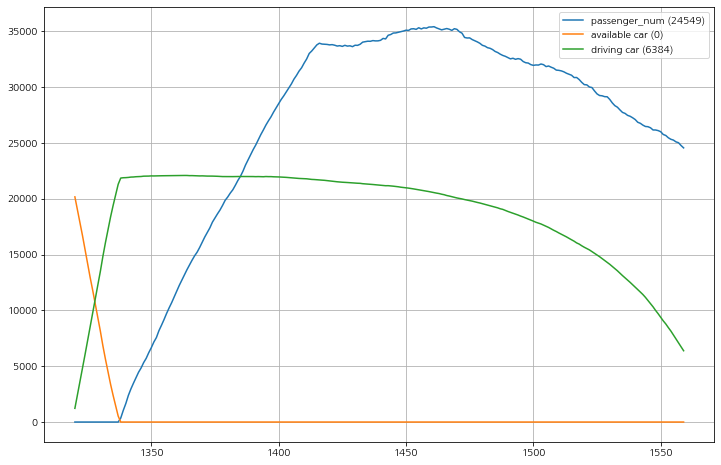

100%|██████████| 240/240 [27:49<00:00,  6.96s/it]


In [16]:
result = dispatch_module(passenger_test, taxi_test, 30)  # 알고리즘

In [19]:
# save
with open('result_scen_1.pickle', 'wb') as f:
    pickle.dump(result, f)

In [20]:
passenger_test, taxi_test = select_scenario(passenger, taxi, 'scen_2')  # 시나리오 별 택시, 승객 증감

Start - scen_2


In [ ]:
result = dispatch_module(passenger_test, taxi_test, 30)  # 알고리즘

In [22]:
# save
with open('result_scen_2.pickle', 'wb') as f:
    pickle.dump(result, f)

In [23]:
passenger_test, taxi_test = select_scenario(passenger, taxi, 'scen_3')  # 시나리오 별 택시, 승객 증감

Start - scen_3


In [ ]:
result = dispatch_module(passenger_test, taxi_test, 30)  # 알고리즘

In [25]:
# save
with open('result_scen_3.pickle', 'wb') as f:
    pickle.dump(result, f)

In [16]:
passenger_test, taxi_test = select_scenario(passenger, taxi, 'scen_4')  # 시나리오 별 택시, 승객 증감

Start - scen_4


In [ ]:
result = dispatch_module(passenger_test, taxi_test, 30)  # 알고리즘

In [18]:
# save
with open('result_scen_4.pickle', 'wb') as f:
    pickle.dump(result, f)

In [2]:
#
### Scenario1
#
import pickle

with open('./result_data/all_data/result_scen_1.pickle', 'rb') as f:
    result_1 = pickle.load(f)

waiting_ps_1 ,empty_tx_1, drive_tx_1 = result_1[-3]
t = list(range(1320, 1560))

#
### Scenario2
#

with open('./result_data/all_data/result_scen_2.pickle', 'rb') as f:
    result_2 = pickle.load(f)

waiting_ps_2 ,empty_tx_2, drive_tx_2 = result_2[-3]
#
### Scenario3
#

with open('./result_data/all_data/result_scen_3.pickle', 'rb') as f:
    result_3 = pickle.load(f)

waiting_ps_3 ,empty_tx_3, drive_tx_3 = result_3[-3]

#
### Scenario4
#

with open('./result_data/all_data/result_scen_4.pickle', 'rb') as f:
    result_4 = pickle.load(f)

waiting_ps_4, empty_tx_4, drive_tx_4 = result_4[-3]

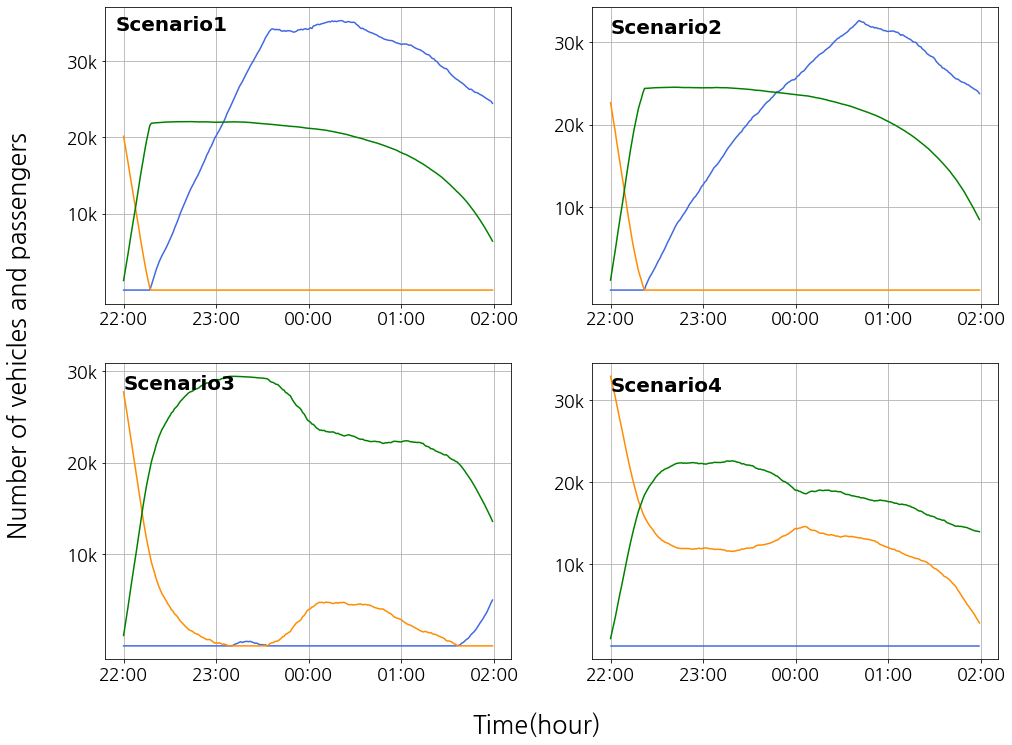

In [7]:
font1 = {'family': 'Times New Roman',
         'color':  'black',
         'weight': 'bold',
         'size': 20}

fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(16)

fig.text(0.5, 0.04, 'Time(hour)', ha='center', fontsize=25)
fig.text(0.04, 0.5, 'Number of vehicles and passengers', va='center', rotation='vertical', fontsize=25)

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.plot(t, waiting_ps_1, color='royalblue')
ax1.plot(t, empty_tx_1 , color='darkorange')
ax1.plot(t, drive_tx_1, color='green')
ax1.set_xticks([1320, 1380, 1440, 1500, 1560],['22:00', '23:00', '00:00', '01:00', '02:00'], fontsize=18)
ax1.set_yticks([10000,20000,30000],['10k','20k','30k'], fontsize=18)
ax1.text(1315, 34000, 'Scenario1', fontdict=font1)


ax2.plot(t, waiting_ps_2, color='royalblue')
ax2.plot(t, empty_tx_2 , color='darkorange')
ax2.plot(t, drive_tx_2, color='green')
ax2.set_xticks([1320, 1380, 1440, 1500, 1560],['22:00', '23:00', '00:00', '01:00', '02:00'], fontsize=18)
ax2.set_yticks([10000,20000,30000],['10k','20k','30k'], fontsize=18)
ax2.text(1320, 31000, 'Scenario2', fontdict=font1)

ax3.plot(t, waiting_ps_3, color='royalblue')
ax3.plot(t, empty_tx_3, color='darkorange')
ax3.plot(t, drive_tx_3, color='green')
ax3.set_xticks([1320, 1380, 1440, 1500, 1560],['22:00', '23:00', '00:00', '01:00', '02:00'], fontsize=18)
ax3.set_yticks([10000,20000,30000],['10k','20k','30k'], fontsize=18)
ax3.text(1320, 28000, 'Scenario3', fontdict=font1)

ax4.plot(t, waiting_ps_4, color='royalblue')
ax4.plot(t, empty_tx_4, color='darkorange')
ax4.plot(t, drive_tx_4, color='green')
ax4.set_xticks([1320, 1380, 1440, 1500, 1560],['22:00', '23:00', '00:00', '01:00', '02:00'], fontsize=18)
ax4.set_yticks([10000,20000,30000],['10k','20k','30k'], fontsize=18)
ax4.text(1320, 31000, 'Scenario4', fontdict=font1)
ax4.grid(True)
plt.show()    

In [12]:
#
### Scenario2
#

with open('./result_data/all_data/result_scen_2.pickle', 'rb') as f:
    result = pickle.load(f)

waiting_ps ,empty_tx, drive_tx = result[-3]
t = list(range(1320, 1560))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


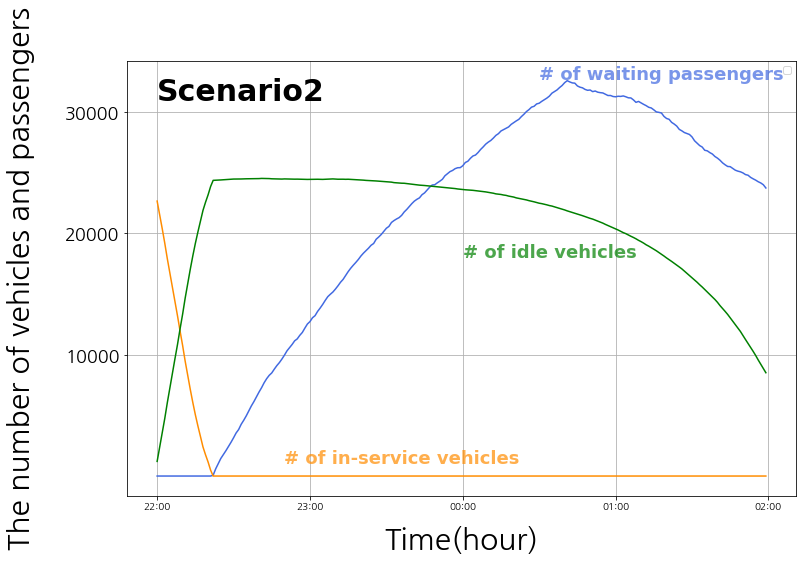

In [18]:
font1 = {'family': 'Times New Roman',
         'color':  'black',
         'weight': 'bold',
         'size': 30}
font2 = {'family': 'Times New Roman',
         'color':  'royalblue',
         'weight': 'bold',
         'size': 18,
         'alpha': 0.7}
font3 = {'family': 'Times New Roman',
         'color':  'darkorange',
         'weight': 'bold',
         'size': 18,
         'alpha': 0.7}
font4 = {'family': 'Times New Roman',
         'color':  'green',
         'weight': 'bold',
         'size': 18,
         'alpha': 0.7}


plt.figure(figsize=(12, 8))
plt.rcParams['axes.grid'] = True 
plt.plot(t, waiting_ps, color='royalblue')
plt.plot(t, empty_tx , color='darkorange')
plt.plot(t, drive_tx, color='green')
plt.xticks([1320, 1380, 1440, 1500, 1560],['22:00', '23:00', '00:00', '01:00', '02:00'])
plt.yticks([10000,20000,30000], fontsize=18)
plt.xlabel('Time(hour)',labelpad = 15 ,fontdict={'size':30})
plt.ylabel('The number of vehicles and passengers', labelpad=30,fontdict={'size':30})
plt.text(1320, 31000, 'Scenario2', fontdict=font1)
plt.text(1470, 32700, '# of waiting passengers', fontdict=font2)
plt.text(1370, 1000, '# of in-service vehicles', fontdict=font3)
plt.text(1440, 18000, '# of idle vehicles', fontdict=font4)
plt.legend()
plt.show()    

In [19]:
#
### Scenario3
#

with open('./result_data/all_data/result_scen_3.pickle', 'rb') as f:
    result = pickle.load(f)

waiting_ps ,empty_tx, drive_tx = result[-3]
t = list(range(1320, 1560))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


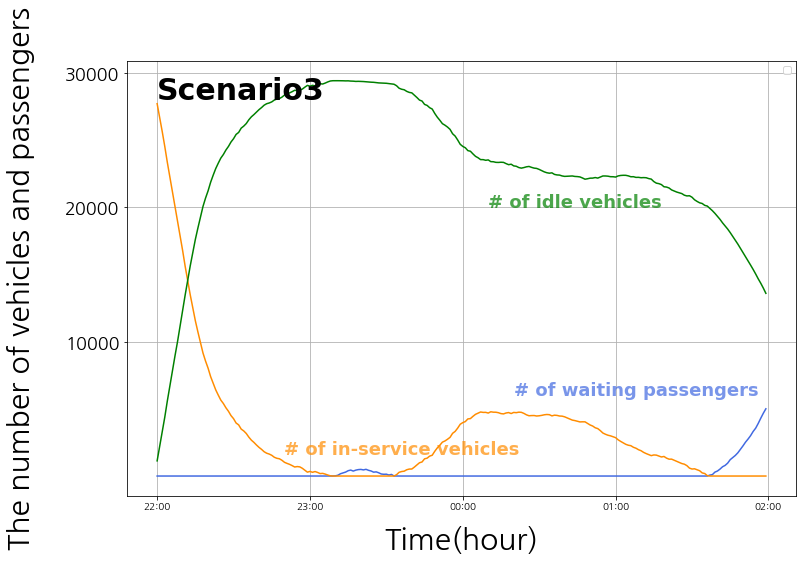

In [38]:
font1 = {'family': 'Times New Roman',
         'color':  'black',
         'weight': 'bold',
         'size': 30}
font2 = {'family': 'Times New Roman',
         'color':  'royalblue',
         'weight': 'bold',
         'size': 18,
         'alpha': 0.7}
font3 = {'family': 'Times New Roman',
         'color':  'darkorange',
         'weight': 'bold',
         'size': 18,
         'alpha': 0.7}
font4 = {'family': 'Times New Roman',
         'color':  'green',
         'weight': 'bold',
         'size': 18,
         'alpha': 0.7}


plt.figure(figsize=(12, 8))
plt.rcParams['axes.grid'] = True 
plt.plot(t, waiting_ps, color='royalblue')
plt.plot(t, empty_tx , color='darkorange')
plt.plot(t, drive_tx, color='green')
plt.xticks([1320, 1380, 1440, 1500, 1560],['22:00', '23:00', '00:00', '01:00', '02:00'])
plt.yticks([10000,20000,30000], fontsize=18)
plt.xlabel('Time(hour)',labelpad = 15 ,fontdict={'size':30})
plt.ylabel('The number of vehicles and passengers', labelpad=30,fontdict={'size':30})
plt.text(1320, 28000, 'Scenario3', fontdict=font1)
plt.text(1460, 6000, '# of waiting passengers', fontdict=font2)
plt.text(1370, 1600, '# of in-service vehicles', fontdict=font3)
plt.text(1450, 20000, '# of idle vehicles', fontdict=font4)
plt.legend()
plt.show()    

In [39]:
#
### Scenario4
#

with open('./result_data/all_data/result_scen_4.pickle', 'rb') as f:
    result = pickle.load(f)

waiting_ps ,empty_tx, drive_tx = result[-3]
t = list(range(1320, 1560))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


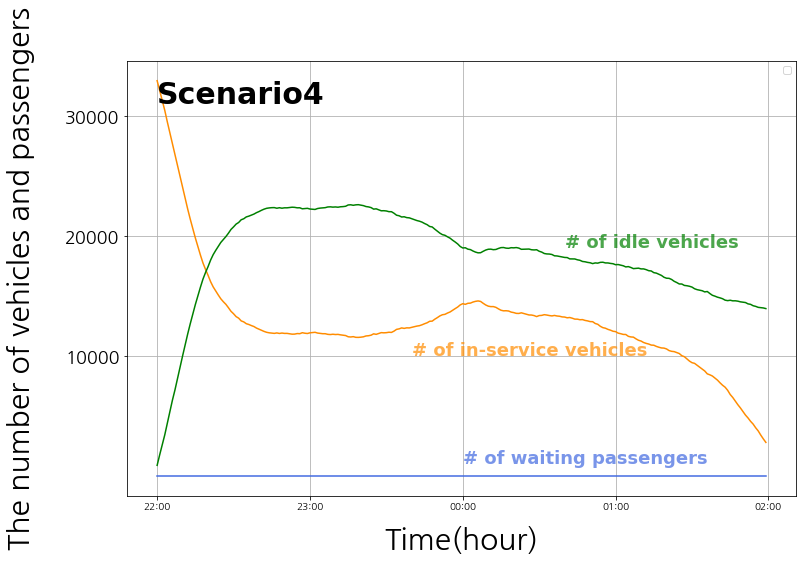

In [40]:
font1 = {'family': 'Times New Roman',
         'color':  'black',
         'weight': 'bold',
         'size': 30}
font2 = {'family': 'Times New Roman',
         'color':  'royalblue',
         'weight': 'bold',
         'size': 18,
         'alpha': 0.7}
font3 = {'family': 'Times New Roman',
         'color':  'darkorange',
         'weight': 'bold',
         'size': 18,
         'alpha': 0.7}
font4 = {'family': 'Times New Roman',
         'color':  'green',
         'weight': 'bold',
         'size': 18,
         'alpha': 0.7}


plt.figure(figsize=(12, 8))
plt.rcParams['axes.grid'] = True 
plt.plot(t, waiting_ps, color='royalblue')
plt.plot(t, empty_tx , color='darkorange')
plt.plot(t, drive_tx, color='green')
plt.xticks([1320, 1380, 1440, 1500, 1560],['22:00', '23:00', '00:00', '01:00', '02:00'])
plt.yticks([10000,20000,30000], fontsize=18)
plt.xlabel('Time(hour)',labelpad = 15 ,fontdict={'size':30})
plt.ylabel('The number of vehicles and passengers', labelpad=30,fontdict={'size':30})
plt.text(1320, 31000, 'Scenario4', fontdict=font1)
plt.text(1440, 1000, '# of waiting passengers', fontdict=font2)
plt.text(1420, 10000,'# of in-service vehicles', fontdict=font3)
plt.text(1480, 19000, '# of idle vehicles', fontdict=font4)
plt.legend()
plt.show()    

---

In [19]:
empty_taxi = result[-1]

t = pd.DataFrame(result[-2][0])
t['s'] = [sum(i) for i in t['timestamps']]
t = t.loc[~t['s'].isna()]
t = t.drop('s', axis=1)
trips = [{'vendor':i[1]['vendor'], 'trips':i[1]['trips'], 'timestamps':i[1]['timestamps']} for i in t.iterrows()]

In [34]:
# - all_trips
with open(f'./result_data/scen_1/visualization_data/scen1_trips.json', 'w') as f:
    json.dump(trips,f)

In [23]:
import pandas as pd 
import numpy as np

trips = pd.DataFrame(trips)

trips['start_time'] = [i[0] for i in trips['timestamps']]
trips['end_time'] = [i[-1] for i in trips['timestamps']]

trips = trips.loc[trips['start_time'] < 1440]

trips['timestamps'] = [np.round(np.array(i),3).tolist()for i in trips['timestamps']]

bins = [i for i in range(1320, 1441, 1)]
labels = [i for i in range(1320, 1440, 1)]

time_cut = pd.cut(trips['start_time'], bins=bins,right=False ,labels=labels)

trips['time_cut'] = time_cut

import json

for i in labels:
    sub_trips = trips.loc[trips['time_cut'] == i]
    sub_trips = [{'vendor':i[1]['vendor'], 'trips':i[1]['trips'], 'timestamps':i[1]['timestamps']} for i in sub_trips.iterrows()]
    with open(f'./result_data/scen_1/visual_data/scen_1_trips_{i}.json', 'w') as f:
        json.dump(sub_trips, f)

In [29]:
#
### visualization - trips, ps_loc data 
#
# - passenger
with open(f'./result_data/scen_1/visualization_data/ps_location.json', 'w') as f:
    json.dump(result[-2][1],f)

In [25]:
empty_taxi = pd.DataFrame(empty_taxi)

In [26]:
empty_taxi.columns = ['loc', 'timestamps']

In [27]:
empty_taxi = [{'loc':i[1]['loc'], 'timestamps':i[1]['timestamps']} for i in empty_taxi.iterrows()]

In [30]:
with open(f'./result_data/scen_1/visualization_data/empty_taxi.json', 'w') as f:
    json.dump(empty_taxi,f)

---

In [108]:
### 전체 결과값 저장
# save
with open('result_scen_1.pickle', 'wb') as f:
    pickle.dump(result, f)

In [ ]:
# load
with open('result_scen_1.pickle', 'rb') as f:
    result = pickle.load(f)

---

In [13]:
import pandas as pd 
import numpy as np

trips = pd.DataFrame(trips)

trips['start_time'] = [i[0] for i in trips['timestamps']]
trips['end_time'] = [i[-1] for i in trips['timestamps']]

trips = trips.loc[trips['start_time'] < 1440]

trips['timestamps'] = [np.round(np.array(i),3).tolist()for i in trips['timestamps']]

bins = [i for i in range(1320, 1441, 1)]
labels = [i for i in range(1320, 1440, 1)]

time_cut = pd.cut(trips['start_time'], bins=bins,right=False ,labels=labels)

trips['time_cut'] = time_cut

import json

for i in labels:
    sub_trips = trips.loc[trips['time_cut'] == i]
    sub_trips = [{'vendor':i[1]['vendor'], 'trips':i[1]['trips'], 'timestamps':i[1]['timestamps']} for i in sub_trips.iterrows()]
    with open(f'./result_data/visual_data/trips_{i}.json', 'w') as f:
        json.dump(sub_trips, f)

In [114]:
import json

for i in labels:
    sub_trips = trips.loc[trips['time_cut'] == i]
    sub_trips = [{'vendor':i[1]['vendor'], 'trips':i[1]['trips'], 'timestamps':i[1]['timestamps']} for i in sub_trips.iterrows()]
    with open(f'./result_data/visual_data/trips_{i}.json', 'w') as f:
        json.dump(sub_trips, f)

---

In [5]:
import plotly.express as px
import plotly.graph_objects as go 

all_fail_data = result[0].copy()
ps_final_inf = result[1]
empty_tx, drive_tx = result[3]
taxi_inf = result[2]

In [115]:
# 탑승했어도 60분 이상 기다려서 탑승 했을 시 실패로 간주
wait_60_over = pd.DataFrame()
wait_60_over['wait_time'] = ps_final_inf['dispatch_time'] + ps_final_inf['wait_time']
wait_60_over['time'] = ps_final_inf['time']
wait_60_over = wait_60_over.loc[wait_60_over['wait_time'] >= 60]

In [116]:
###### Page1
# 1-a
page1_1a = f"전체 호출 수 - 총 {len(passenger_test)}건, 실패 호출 수 - 총 {len(all_fail_data) + len(wait_60_over)}건, 호출 실패율 - {round((len(all_fail_data)+len(wait_60_over))/len(passenger)*100,2)}%"
page1_1a

'전체 호출 수 - 총 262180건, 실패 호출 수 - 총 74481건, 호출 실패율 - 48.15%'

In [ ]:
# 1-b1
bins = [i*60 for i in range(22,27)]
labels = [i for i in range(22,26)]

all_fail_data["ride_dtime"] = all_fail_data["ride_dtime"] + 30
all_fail_data.columns = ["fail_time", "geometry"]

fail_passenger_distribution = pd.DataFrame(pd.cut(all_fail_data["fail_time"], bins = bins, right=False, labels = labels).value_counts(sort=False)).reset_index()
call_passenger_distribution = pd.DataFrame(pd.cut(passenger_test["ride_dtime"], bins = bins, right=False, labels = labels).value_counts(sort=False)).reset_index()
fail_passenger_distribution.columns = ["fail_time", "cnt"]
call_passenger_distribution.columns = ["call_time", "cnt"]

# 60분 이상 대기 후 탑승자 추가
extra_fail = pd.DataFrame(pd.cut(wait_60_over["time"], bins = bins, right=False, labels = labels).value_counts(sort=False)).reset_index()
extra_fail.columns = ["call_time", "cnt"]
fail_passenger_distribution['cnt'] = fail_passenger_distribution['cnt'] + extra_fail['cnt']


page1_1b = go.Figure()
page1_1b.add_trace(go.Scatter(x=call_passenger_distribution["call_time"], y=call_passenger_distribution["cnt"],
                         mode="lines+markers", 
                         name="콜 승객"))
page1_1b.add_trace(go.Scatter(x=fail_passenger_distribution["fail_time"], y=fail_passenger_distribution["cnt"],
                         mode="lines+markers",
                         name="콜 실패 승객"))
page1_1b.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [i for i in range(22,26)],
        ticktext = [f"{i}시" for i in ['22', '23', '24', '01']]
    ),
    yaxis = dict(
        tickmode = 'array',
        tickvals = [i for i in range(0,70001, 10000)],
        ticktext = [i for i in range(0,70001, 10000)],
    )
)
page1_1b.update_xaxes(
    range=[21.5, 25.5],
    title_text = "시간")
page1_1b.update_yaxes(
        title_text = "승객수")

page1_1b.update_layout(
    legend={"x": 0.9, "y":1},
    margin={"l":0,"r":0,"b":0,"t":0,"pad":0})

page1_1b

In [ ]:
waiting_time = pd.DataFrame([(ps_final_inf["dispatch_time"] + ps_final_inf["wait_time"]).tolist(), ps_final_inf["time"].tolist()]).T
waiting_time.columns = ["waiting_time", "time"]
waiting_time['waiting_time'][waiting_time['waiting_time'] < 0] = 0

fail_waiting = pd.DataFrame(all_fail_data["fail_time"].values - 30, columns=["time"])
fail_waiting["waiting_time"] = 30

waiting_time = pd.concat([waiting_time, fail_waiting], axis=0).reset_index(drop=True)
waiting_time["waiting_time"] = np.round(waiting_time["waiting_time"].values,2)

page1_2a = go.Figure()
page1_2a.add_trace(go.Box(y=waiting_time["waiting_time"],hoverinfo='x+y'))
page1_2a.update_layout(
    title={'text': f"전체 기간동안의 평균 승객 대기시간 - {round(np.mean(waiting_time['waiting_time']))}분",
           'x':0.5,
           'y':0.9},
    margin={"l":0,"r":0,"b":0,"t":50,"pad":0})
page1_2a.update_xaxes(
        visible = False)
page1_2a.update_yaxes(
        title_text = "대기시간",
        visible=True)

page1_2a

In [98]:
# 2-b
waiting_time["time_cut"] = pd.cut(waiting_time["time"], bins = bins, right=False, labels = labels).tolist()

top_5per_waiting_time = []
time = []
for i in waiting_time.groupby(["time_cut"]):
    sample = round(len(waiting_time.loc[waiting_time["time_cut"] == i[0]]) * 0.05)
    sample = 1 if sample < 1 else sample
    subset = i[1].sort_values("waiting_time", ascending=False).head(sample)
    top_5per_waiting_time.extend([np.mean(subset["waiting_time"])])
    time.extend([i[0]])
    
page1_2b = go.Figure()
page1_2b.add_trace(go.Box(x=waiting_time["time_cut"], y=waiting_time["waiting_time"], showlegend=False))
page1_2b.add_trace(go.Scatter(x=time, y=top_5per_waiting_time,showlegend=True, name = "상위 5%"))
page1_2b.update_yaxes(
        title_text = "분")
page1_2b.update_layout(showlegend=False)
page1_2b.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [i for i in range(22,26)],
        ticktext = [f"{i}시" for i in ['22', '23', '24', '01']],
        range=[21.5,25.5]),
    title={'text': '시간대별 승객 대기시간',
           'x':0.5,
           'y':0.9},
    showlegend = True,
    legend= dict(x=0.9, y=0.9),
    margin={"l":0,"r":0,"b":0,"t":50,"pad":0})

page1_2b.write_html('./page1_2b.html')
    

In [99]:
total_driving_time = round(sum(taxi_inf['total_to_ps_drive_time'] + taxi_inf['total_ps_drive_time']) / 60)
print(f'총 운행 차량 대수 : {len(taxi_inf)}대 | 총 운행 거리: {total_driving_time} 시/일')

총 운행 차량 대수 : 24910대 | 총 운행 거리: 74023 시/일


In [100]:
###### Page2
# 1
empty_tx_per = [round(i/(i+j), 2) for i,j in zip(empty_tx, drive_tx)]
drive_tx_per = [1-i for i in empty_tx_per]
t = [i for i in range(1320, 1560)]

page2_1 = go.Figure()
page2_1.add_trace(go.Bar(
    x=t,
    y=empty_tx_per,
    name='빈 차량',
    marker_color='indianred'
))
page2_1.add_trace(go.Bar(
    x=t,
    y=drive_tx_per,
    name='운행중인 차량',
    marker_color='blue'
))
page2_1.update_layout(bargap=0)
page2_1.update_layout(
    barmode="stack")
page2_1.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [i*60 for i in range(22,26)],
        ticktext = [f"{i}시" for i in ['22', '23', '24', '01']]),
    yaxis = dict(
        tickmode = 'array',
        tickvals = [0.2, 0.4, 0.6, 0.8, 1.0],
        ticktext = ["20%", "40%", "60%", "80%", "100%"]),
    legend = dict(x=0.9, y=1.1),
    margin={"l":0,"r":20,"b":0,"t":30,"pad":0}
)
page2_1.write_html('./page2_1.html')

In [101]:

# 2 
taxi_driving_nm = (np.array(drive_tx) + np.array(empty_tx)).tolist()
taxi_driving_nm = taxi_driving_nm[::60]

page2_2 = px.bar(x=[i for i in range(22,26)], y=taxi_driving_nm)

page2_2.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [i for i in range(22,26)],
        ticktext = [f"{i}시" for i in ['22', '23', '24', '01']],
        title=""),
    yaxis = dict(
        tickmode = 'array',
        tickvals = [i for i in range(0,50001, 10000)],
        ticktext = [i for i in range(0,50001, 10000)],
        title="차량대수"),
    margin={"l":0,"r":20,"b":0,"t":0,"pad":0})


page2_2.write_html('./page2_2.html')